# Implementation and Comparison of different Steganographic techniques

## Objetivo Principal

Nesse projeto iremos implementar diferentes técnicas de estenografia para esconder dados em imagens digitais. Iremos comparar diferentes técnicas no domínio espacial e no frequencial com relação à qualidade do objeto resultante (objeto stego) e a distorção em relação à imagem original (imagem cover). Nosso objetivo é aprender sobre a aplicação de Estenografia em Imagens assim como seus efeitos.

## Imagens de Entrada

Para essa aplicação, qualquer conjunto de imagens funcionaria. No nosso projeto, escolhemos 39 imagens da base de dados de imagens Cover do desafio do Kaggle [ALASKA2 Image Steganalysis](https://www.kaggle.com/c/alaska2-image-steganalysis/data) para imbutir com dados. Essa base foi escolhida por ter acesso simples a uma base organizada de imagens JPEG e por possuir grande similaridade ao tema deste projeto.

Para as demonstrações nas seções seguintes, será utilizada a imagem contida em [cover_images/20.jpg](https://github.com/eduardo550/SCC0251-FinalProject/blob/main/cover_images/20.jpg)

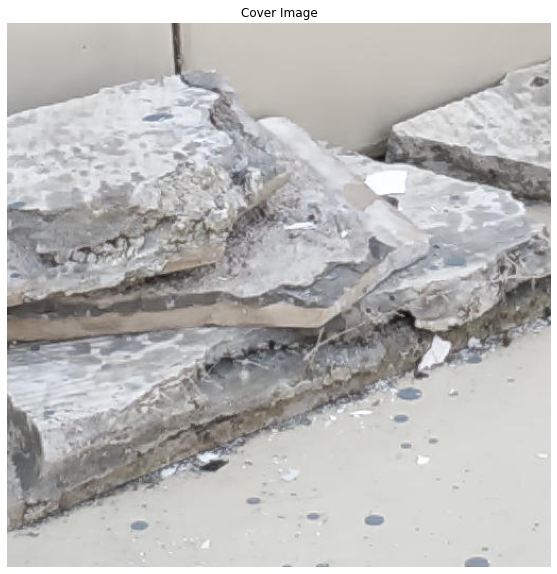

In [1]:
import imageio as io
import matplotlib.pyplot as plt

cover_image = io.imread("cover_images/20.jpg")

plt.rcParams['figure.figsize'] = [15, 10]
plt.title("Cover Image")
plt.axis("off")
plt.imshow(cover_image)

## Descrição de Passos e Métodos

Nesse projeto utilizamos arquivos de texto como dados secretos. Qualquer tipo de arquivo deve servir, mas o conteúdo textual deixa claro o funcionamento correto dos algoritmos. Foram utilizados dois arquivos de tamanhos diferentes:
* [small.txt](testdata/small.txt). 15 bytes, contém a string "Attack at Dawn\n"
* [large.txt](testdata/large.txt). Conteúdo textual de H.P. Lovecraft. "The Call of Cthulhu", obra de acervo público. Aprox. 70 Kb.

Para a demonstração dos algoritmos, o arquivo **large.txt** será utilizado como payload.

In [2]:
import utils    # Módulo implementado nesse projeto, contém funções de conveniência fora dos algoritmos de estenografia

# A função read_payload retorna um objeto bytes contendo o conteúdo do arquivo em binário, 
# com um cabeçalho adicional de 8 bytes que contém a quantidade de bytes do arquivo
payload = utils.read_payload("testdata/large.txt")
payload_size = len(payload)
print(f"Payload has {payload_size} bytes")

Payload has 70163 bytes


As medidas de distorção que serão utilizadas são o Mean Squared Error (mse) entre a imagem cover e imagem stego, e o Peak Signal to Noise Ratio(psnr), medida de distorção de sinais comumente encontrada na literatura. Elas são implementadas no módulo metrics.py, criado nesse projeto.

Para cada técnica de estenogafia que escolhemos, foi implementada uma ferramenta que executa o seu algoritmo. Elas podem ser executadas independentemente, ou ser importadas como módulos, que é o que será feito nesse notebook. Cada módulo contém pelo menos as funções:
1. max_capacity(cover) -> retorna o número de bytes que a técnica comporta de acordo com a imagem cover.
2. embed(cover, payload) -> faz o ocultamento do payload na imagem, de acordo com a técnica escolhida. Não checa se o payload é grande demais para a imagem, com o payload necessitando ser validado por max_capacity(). Retorna a imagem stego, em formato (R, G, B)
3. extract(stego) -> a partir de uma imagem stego, faz a extração do conteúdo binário escondido. A função assume que existe conteúdo válido dentro da imagem, e seu comportamento é indefinido caso contrário. Retorna um objeto bytes, com o conteúdo do payload original.

As técnicas de Estenografia que foram implementadas são:
1. Least Significant Bit embedding.
2. Edge-based encoding, com embedding em 2 bits
3. Integer Wavelet Transform com embedding na função de módulo

### Least Significant Bit (LSB)
A técnica mais famosa e mais simples, consiste em substituir o bit menos significativo de cada pixel da imagem pelos bits do payload. Assim, a capacidade máxima de uma imagem é igual a quantidade de pixels / 8. Foi implementada no módulo [lsb_embed.py]

In [3]:
import lsb_embed

lsb = lsb_embed.Steg(cover_image)
lsb_max_capacity = lsb.max_capacity()
print(f"Cover has max embedding capacity of {lsb_max_capacity} bytes")

Cover has max embedding capacity of 98304.0 bytes


Gerando o objeto stego

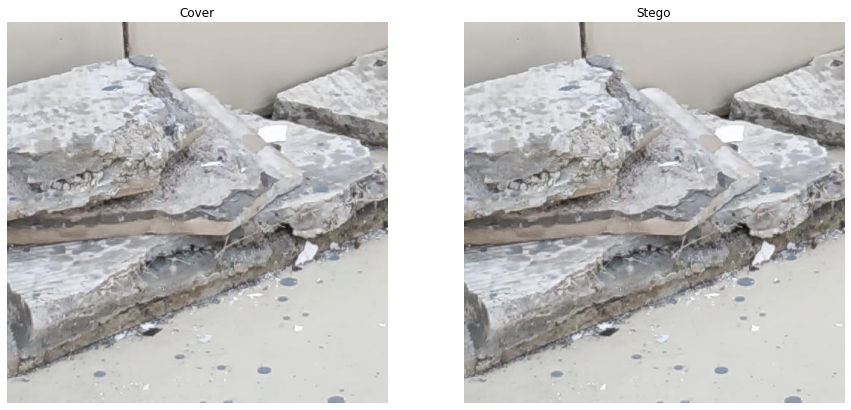

In [4]:
assert payload_size <= lsb_max_capacity

lsb_stego = lsb.embed(payload)

utils.plot_cover_stego(cover_image, lsb_stego)

# TODO falar sobre as imagens

### Edge-based Encoding (EBE)
Essa técnica seleciona os pixels de borda para esconder os dados. A teoria é que o olho nu não irá perceber distorções médias em regiões de alta transição de intensidade (bordas). Para essa seleção, foram utilizados os filtros de Sobel para obter a lista de pixels de borda, e os 2 últimos bits são substituídos, para compensar a redução de capacidade comparada a técnica anterior. É implementada no módulo [edge_embed.py].

A capacidade máxima depende da quantidade de pixels de borda. Para a cover escolhida:

In [5]:
import ebe_embed

ebe = ebe_embed.Steg(cover_image)
edge_capacity = ebe.max_capacity()
print(f"Cover has max embedding capacity of {edge_capacity} bytes")

Cover has max embedding capacity of 70474.5 bytes


Fazendo a operação

In [6]:
assert payload_size <= edge_capacity

edge_stego = ebe.embed(payload)

utils.plot_cover_stego(cover_image, edge_stego)

SteganographyException: No available slot remaining (image filled)

# TODO falar sobre as imagens

### Integer Wavelet Transform (IWT)
Uma técnica experimental adaptada de [High quality image steganography on integer Haar Wavelet Transform using modulus function][1]. Ela difere das duas últimas pois o ocultamento acontece no domínio de frequências, assim apenas os pixels não são suficientes para sua detecção. A imagem é transformada com uma adaptação de *Discrete Haar Wavelet Transform* utilizando um *lifting scheme*, que faz com que os coeficientes sejam inteiros. Isso é útil para estenografia pois os dados da imagem necessitam estar na forma inteira para que seja possível fazer as operações em bits.
A IWT resulta em 4 faixas de coeficientes: cA, cH, cV, cD, que resultam da aplicação das operações em blocos 2x2 da imagem 2D
* cA = as médias dos pixels, na horizontal e vertical
* cH = as diferenças dos pixels horizontais (na mesma linha)
* cV = as diferenças dos pixels verticais (na mesma coluna)
* cD = a soma das diferenças cH e cD

Essa técnica também vai um passo além das outras no momento da inclusão do dado secreto. Ao invés de substituir apenas os bits menos significativos, o algoritmo divide a imagem em pares de coeficientes disjuntos, sendo que cada par é definido pelo pixel ij e seu vizinho i(j+1). Esses coeficientes são alterados para ij' e i(j+1)', de modo que bits do dado oculto se tornam o resultado da operação: ij' + i(j+1)' mod 2^b, sendo b o número de bits do dado. Após a alteração dos coeficientes, é aplicada a transformada inversa, e a imagem stego é obtida com qualidade comparável a Cover. A técnica é implementada em [wavelet_embed.py].

A capacidade máxima para IWT é calculada com o número de coeficientes obtidos após a transformada / 2, pois o payload é obtido com os pares de coefs. Reduzindo mais ainda a capacidade, os coeficientes de cA não são alterados, pois causam a maior distorção na imagem original.

In [ ]:
import wavelet_embed

iwt_capacity = wavelet_embed.max_capacity(cover_image)

print(f"Cover has max embedding capacity of {iwt_capacity} bytes")

Cover has max embedding capacity of 73728 bytes


Geração da imagem manipulada

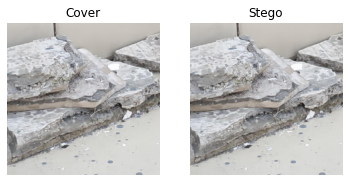

In [ ]:
assert payload_size <= iwt_capacity

iwt_stego = wavelet_embed.embed(cover_image, payload)

utils.plot_cover_stego(cover_image, iwt_stego)

Como nas outras implementações, a imagem resultante não possui diferenças perceptíveis comparada à original.

Com as imagens geradas, as métricas de distorção são calculadas e comparadas em conjunto.

In [ ]:
import metrics

lsb_mse = metrics.mse(cover_image, lsb_stego)
lsb_psnr = metrics.psnr(cover_image, lsb_stego)

edge_mse = metrics.mse(cover_image, edge_stego)
edge_psnr = metrics.psnr(cover_image, edge_stego)

iwt_mse = metrics.mse(cover_image, edge_stego)
iwt_psnr = metrics.psnr(cover_image, edge_stego)

# TODO fazer uma tabela (pandas dataframe) com as métricas

NameError: name 'lsb_stego' is not defined

# TODO DISCUTIR SOBRE AS MÉTRICAS OBTIDas QUANDO RODAR

## Resultados obtidos 

In [ ]:
# TODO rodar com todas as imagens, fazer o dataframe

# TODO DISCUTIR

## Nomes e Papéis
* Eduardo de Sousa Siqueira		nUSP: 9278299   Implementação de IWT e construção do Final Report
* Igor Barbosa Grécia Lúcio		nUSP: 9778821   Implementação de LSB e Edge_encoding

[1]:(https://ieeexplore.ieee.org/document/7407781)